# Logistic Regression – Wine Quality (binaire)

Ce notebook applique **la régression logistique** selon le cahier des charges :
- Prédire si un vin est "bon" (≥6) ou "moyen/mauvais" (<6)
- Interprétation simple
- Classification binaire
- Évaluation avec Accuracy, F1-score
- Suivi avec MLflow

## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
# Racine du projet (dossier contenant src/ et dataset/)
_roots = [os.getcwd(), os.path.join(os.getcwd(), '..'), os.path.join(os.getcwd(), '..', '..')]
for _r in _roots:
    _p = os.path.join(os.path.abspath(_r), 'src', 'preprocessing.py')
    if os.path.isfile(_p):
        ROOT = os.path.abspath(_r)
        sys.path.insert(0, os.path.join(ROOT, 'src'))
        break
else:
    raise FileNotFoundError("Dossier 'src' introuvable. Ouvrez le projet ML-project.")
from preprocessing import load_data, clean_data, scale_features, split_data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("sqlite:///c:/Users/pc/Desktop/ML-project/classification/mlflow.db")
mlflow.set_experiment("wine-quality-logistic-regression")

2026/02/14 17:13:39 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/14 17:13:39 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/14 17:13:39 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/14 17:13:39 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/14 17:13:39 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/14 17:13:39 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/14 17:13:39 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/14 17:13:39 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='file:///C:/Users/pc/Desktop/ML-project/classification/mlruns/4', creation_time=1770929494310, experiment_id='4', last_update_time=1770929494310, lifecycle_stage='active', name='wine-quality-logistic-regression', tags={}>

## 2. Chargement et preprocessing

In [2]:
df = load_data(os.path.join(ROOT, "dataset", "winequality-red.csv"))
df = clean_data(df)

# Cible binaire (selon cahier des charges)
df["quality_binary"] = (df["quality"] >= 6).astype(int)

X = df.drop(columns=["quality", "quality_binary"])
y = df["quality_binary"]

# Normalisation
X_scaled, scaler = scale_features(X)

# Train/test split
X_train, X_test, y_train, y_test = split_data(X_scaled, y, test_size=0.2, random_state=42)

print(f"Train set: {X_train.shape[0]} échantillons")
print(f"Test set: {X_test.shape[0]} échantillons")
print(f"Répartition classes (train): {np.bincount(y_train)}")

Train set: 1087 échantillons
Test set: 272 échantillons
Répartition classes (train): [512 575]


## 3. Entraînement du modèle

In [3]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

# Métriques
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

Accuracy: 0.735
F1-score: 0.745
Precision: 0.761
Recall: 0.729

Matrice de confusion:
[[ 95  33]
 [ 39 105]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       128
           1       0.76      0.73      0.74       144

    accuracy                           0.74       272
   macro avg       0.73      0.74      0.73       272
weighted avg       0.74      0.74      0.74       272



## 4. Visualisation de la matrice de confusion

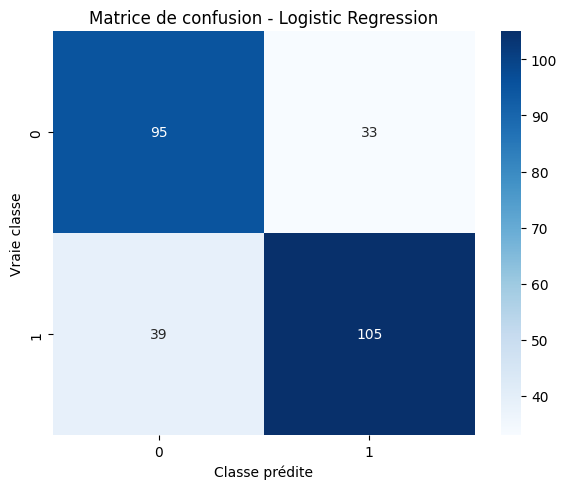

In [4]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion - Logistic Regression')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()
plt.savefig("logistic_confusion_matrix.png")
plt.show()

## 5. MLflow tracking

In [5]:
with mlflow.start_run(run_name="LogisticRegression_binary"):
    mlflow.log_params(log_reg.get_params())
    mlflow.log_metric("accuracy", float(acc))
    mlflow.log_metric("f1_score", float(f1))
    mlflow.log_metric("precision", float(precision))
    mlflow.log_metric("recall", float(recall))
    mlflow.log_artifact("logistic_confusion_matrix.png")
    mlflow.sklearn.log_model(log_reg, "logistic_regression_model")
    print("MLflow run terminé")

2026/02/14 17:13:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


MLflow run terminé
